In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

#### Loading the datasets

In [2]:
sales_df = pd.read_csv('./data/fact_sales.csv')
budget_df = pd.read_csv('./data/fact_budget.csv')
prod_df = pd.read_csv('./data/dim_prod.csv')
cust_df = pd.read_csv('./data/dim_cust.csv')

Taking only the sales done in 2023 as this is a yearly report

In [3]:
sales_df.head()

,ProductKey,OrderDateKey,CustomerKey,SalesOrderNumber,SalesAmount
0,381,20220101,16942,SO46700,1000.4375
1,375,20220101,15114,SO46701,2181.5625
2,369,20220101,15116,SO46702,2443.3500
3,337,20220101,20576,SO46703,782.9900
4,370,20220101,13059,SO46704,2443.3500


In [4]:
sales_df = sales_df[sales_df['OrderDateKey'].astype(str).str.startswith('2023')]

In [5]:
sales_df.head()

,ProductKey,OrderDateKey,CustomerKey,SalesOrderNumber,SalesAmount
3397,361,20230101,11249,SO51247,2294.99
3398,477,20230101,11249,SO51247,4.99
3399,478,20230101,11249,SO51247,9.99
3400,378,20230101,12307,SO51248,2443.35
3401,353,20230101,11334,SO51249,2319.99


### 1. Sales by Gender 

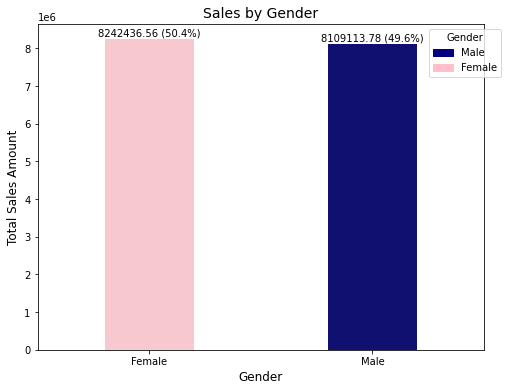

In [25]:
#Merging Sales and customer Data
sales_by_gender = sales_df.merge(cust_df, on='CustomerKey', how='inner')

# Group by gender and calculate total sales
gender_sales = sales_by_gender.groupby('Gender')['SalesAmount'].sum().reset_index()

# Calculate percentage contribution
total_sales = gender_sales['SalesAmount'].sum()
gender_sales['Percentage'] = (gender_sales['SalesAmount'] / total_sales) * 100

# Create a bar plot with seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=gender_sales, x='Gender', y='SalesAmount', width=0.4, palette={'Male': 'navy', 'Female': 'pink'})

# Add total sales values on top of the bars
for index, row in gender_sales.iterrows():
    plt.text(x=index, y=row['SalesAmount'] + 0.01 * row['SalesAmount'], 
             s=f"{row['SalesAmount']:.2f} ({row['Percentage']:.1f}%)", 
             ha='center', fontsize=10)

# Add legend for colors
handles = [plt.Rectangle((0, 0), 1, 1, color= 'navy', label='Male'),
           plt.Rectangle((0, 0), 1, 1, color= 'pink', label='Female')]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), title='Gender', loc='upper right')    
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])

# Add title and labels
plt.title('Sales by Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
plt.show()

### 2. Sales by City

In [ ]:
# Merge sales and customer datasets
sales_by_location = sales_df.merge(cust_df, on='CustomerKey', how='inner')

# Group by Customer City and calculate total sales
city_sales = sales_by_location.groupby('Customer City')['SalesAmount'].sum().sort_values(ascending=False).head(10)

# Plot sales by top 10 cities
plt.figure(figsize=(10, 6))
sns.barplot(x=city_sales.values, y=city_sales.index, color ='navy')
plt.title('Top 10 Cities by Sales', fontsize=14)
plt.xlabel('Total Sales Amount', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.show()


### 3. Revenue-Generating Customers

#### 3.1 Top 10 Customers

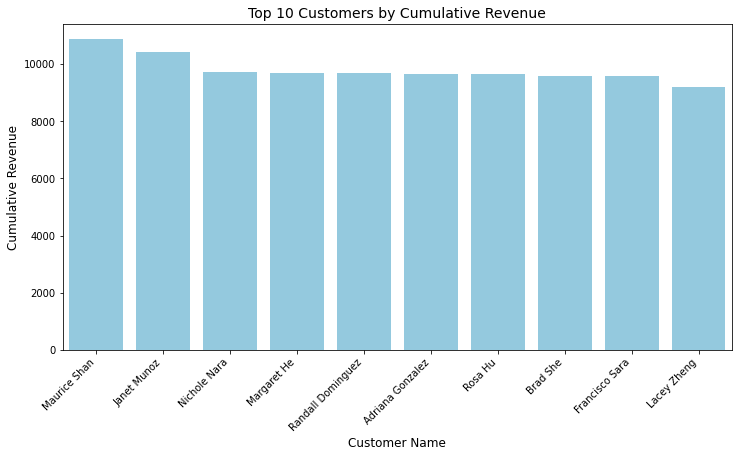

In [7]:
# Group sales data by CustomerKey and calculate total revenue
top_customers = sales_df.groupby('CustomerKey')['SalesAmount'].sum().sort_values(ascending=False).head(10)

# Merge with customer names from cust_df to replace CustomerKey with names
top_customers = top_customers.reset_index().merge(cust_df[['CustomerKey', 'Full Name']], on='CustomerKey')

# Plot the top 10 customers by revenue
plt.figure(figsize=(12, 6))
sns.barplot(x='Full Name', y='SalesAmount', data=top_customers, color='skyblue')  # Single color
plt.title('Top 10 Customers by Cumulative Revenue', fontsize=14)
plt.xlabel('Customer Name', fontsize=12)
plt.ylabel('Cumulative Revenue', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate names for better visibility
plt.show()


In [8]:
top_customers.head()

,CustomerKey,SalesAmount,Full Name
0,11433,10860.57,Maurice Shan
1,11439,10417.75,Janet Munoz
2,12301,9717.11,Nichole Nara
3,12308,9691.00,Margaret He
4,12131,9687.72,Randall Dominguez


#### 3.2 Pareto Chart

The goal is to understand the contribution of the top-performing customers (e.g., top 10 customers or top 20% of customers) to total revenue. This gives insight into whether a small group of customers is responsible for a significant portion of the revenue. 
For this the Pareto Chart can be applied
- Show the cumulative percentage of total revenue contributed by customers, ranked from highest to lowest.
- Identify the point where the top 30% of customers contribute to revenue

In [9]:
# Pareto Chart
# Group sales data by CustomerKey and calculate total revenue
customer_revenue = sales_df.groupby('CustomerKey')['SalesAmount'].sum().reset_index()
customer_revenue = customer_revenue.sort_values(by='SalesAmount', ascending=False)
customer_revenue['Cumulative Revenue'] = customer_revenue['SalesAmount'].cumsum()
customer_revenue['Cumulative %'] = (customer_revenue['Cumulative Revenue'] / customer_revenue['SalesAmount'].sum()) * 100
cutoff_index = int(len(customer_revenue) * 0.2)

Top 30% customers contribute 43.38% of total sales.


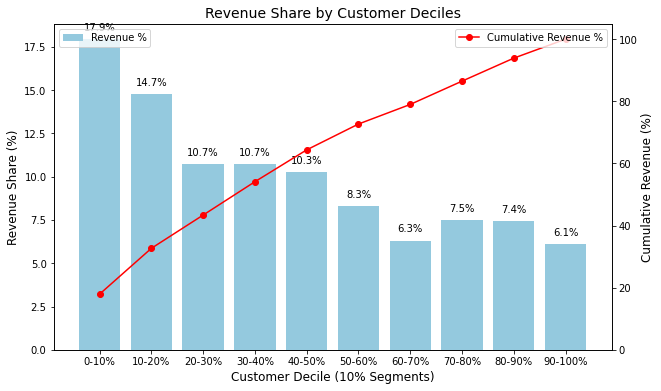

In [10]:
# Pareto Chart - Grouping customers into 10% segments and calculating revenue share
cust_rev = sales_df.groupby('CustomerKey')['SalesAmount'].sum().reset_index()
cust_rev = cust_rev.sort_values(by='SalesAmount', ascending=False)

# Calculate decile segments
cust_rev['Decile'] = pd.qcut(cust_rev.index, q=10, labels=[f'{i*10}-{(i+1)*10}%' for i in range(10)])
decile_rev = cust_rev.groupby('Decile')['SalesAmount'].sum().reset_index()
decile_rev['Revenue %'] = (decile_rev['SalesAmount'] / cust_rev['SalesAmount'].sum()) * 100

decile_rev['Cumulative Revenue %'] = decile_rev['Revenue %'].cumsum()

# Calculate and print contribution for top 30% customers
top_30_cutoff = 3  # Top 30% corresponds to the first 3 deciles (10% + 10% + 10%)
top_30_sales = decile_rev.iloc[:top_30_cutoff]['SalesAmount'].sum()
total_sales = cust_rev['SalesAmount'].sum()
top_30_contribution = (top_30_sales / total_sales) * 100
print(f"Top 30% customers contribute {top_30_contribution:.2f}% of total sales.")

# Plot revenue share by customer decile
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=decile_rev, x='Decile', y='Revenue %', color='skyblue', label='Revenue %')

# Plot cumulative revenue as a line on the same axes
ax2 = ax.twinx()
ax2.plot(range(len(decile_rev)), decile_rev['Cumulative Revenue %'], color='red', marker='o', label='Cumulative Revenue %')

# Add percentage annotations for bars
for index, row in decile_rev.iterrows():
    ax.text(index, row['Revenue %'] + 0.5, f"{row['Revenue %']:.1f}%", ha='center', fontsize=10)

# Labels and Title
ax.set_title('Revenue Share by Customer Deciles', fontsize=14)
ax.set_xlabel('Customer Decile (10% Segments)', fontsize=12)
ax.set_ylabel('Revenue Share (%)', fontsize=12)
ax2.set_ylabel('Cumulative Revenue (%)', fontsize=12)

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.ylim(0, 105)
plt.show()



### 4. Contribution of Top-Performing Products to Total Sales

Top 10% products contribute 44.63% of total sales.


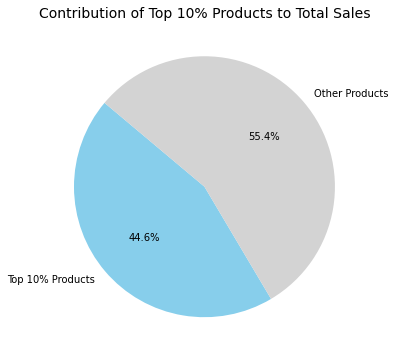

In [11]:
#Merge sales and product datasets
sales_prod = sales_df.merge(prod_df, on='ProductKey', how='inner')

#Group by ProductKey to calculate total sales per product
product_sales = sales_prod.groupby('ProductKey')['SalesAmount'].sum().reset_index()
product_sales = product_sales.sort_values(by='SalesAmount', ascending=False)

#Determine top 10% products
top_10_percent_cutoff = int(len(product_sales) * 0.1)
top_products = product_sales.iloc[:top_10_percent_cutoff]

#Calculate contributions
top_products_sales = top_products['SalesAmount'].sum()
total_sales = product_sales['SalesAmount'].sum()
contribution_percentage = (top_products_sales / total_sales) * 100

print(f"Top 10% products contribute {contribution_percentage:.2f}% of total sales.")

#Visualize pie chart
labels = ['Top 10% Products', 'Other Products']
sizes = [top_products_sales, total_sales - top_products_sales]
colors = ['skyblue', 'lightgray']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Contribution of Top 10% Products to Total Sales', fontsize=14)
plt.show()

### 5. Monthly and Quarterly Sales 

In [12]:
# Extract Month and Quarter from OrderDateKey
sales_df['DateKey'] = pd.to_datetime(sales_df['OrderDateKey'], format='%Y%m%d')
sales_df['Month'] = sales_df['DateKey'].dt.month
sales_df['Quarter'] = sales_df['DateKey'].dt.quarter

# Group by Month and Quarter to calculate total sales
monthly_sales = sales_df.groupby('Month')['SalesAmount'].sum().reset_index()
quarterly_sales = sales_df.groupby('Quarter')['SalesAmount'].sum().reset_index()

# Monthly and Quarterly data prepared; you can now proceed with visualization
monthly_sales.head()

,Month,SalesAmount
0,1,857689.91
1,2,771348.74
2,3,1049907.39
3,4,1046022.77
4,5,1284592.93


In [13]:
quarterly_sales.head()

,Quarter,SalesAmount
0,1,2678946.04
1,2,3973793.48
2,3,4370237.06
3,4,5328573.76


#### 5.1 Monthly Sales trends 

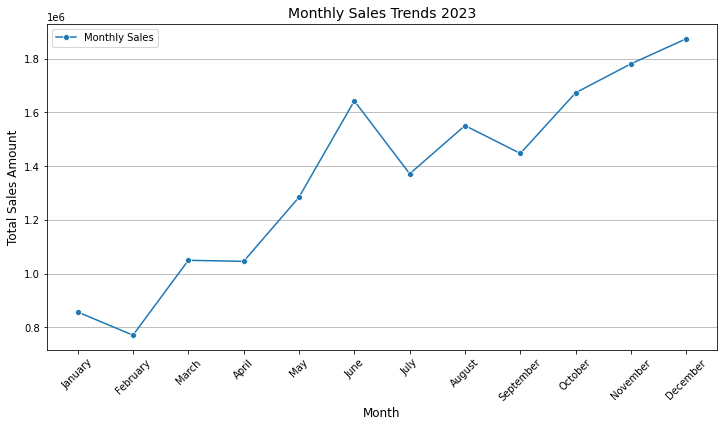

In [14]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales['MonthName'] = monthly_sales['Month'].apply(lambda x: month_names[x - 1])

# Plot sales trends with month names on the X-axis
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='MonthName', y='SalesAmount', marker='o', label='Monthly Sales')
plt.title('Monthly Sales Trends 2023', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.show()

#### 5.2 Returns by Quarter

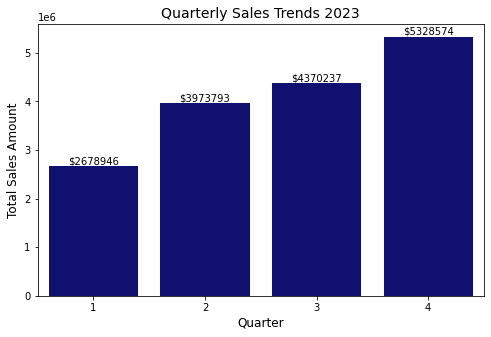

In [15]:
# Step 4: Visualize sales trends by quarter (bar chart)
plt.figure(figsize=(8, 5))
sns.barplot(data=quarterly_sales, x='Quarter', y='SalesAmount', color='navy')
plt.title('Quarterly Sales Trends 2023', fontsize=14)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Total Sales Amount', fontsize=12)
for index, row in quarterly_sales.iterrows():
    plt.text(index, row['SalesAmount'] + 0.01 * row['SalesAmount'], f"${row['SalesAmount']:.0f}", ha='center', fontsize=10)
plt.show()


#### 6.1 Budget comparison

In [16]:
budget_df.head()

,Date,Budget
0,January-22,379665
1,February-22,360220
2,March-22,391676
3,April-22,374843
4,May-22,371747


In [17]:
# Ensure the Date column is in datetime format
budget_df['Date'] = pd.to_datetime(budget_df['Date'], format='%B-%y')

# Filter for 2023
budget_2023 = budget_df[budget_df['Date'].dt.year == 2023]


In [18]:
# Add a Month column for merging with sales_df
budget_2023['Month'] = budget_2023['Date'].dt.month


In [19]:
# Filter sales_df for 2023
sales_2023 = sales_df[sales_df['DateKey'].dt.year == 2023]
actual_sales_2023 = sales_2023.groupby('Month')['SalesAmount'].sum().reset_index()
actual_sales_2023.columns = ['Month', 'ActualSales']

# Merge with budget data
sales_comparison_2023 = actual_sales_2023.merge(budget_2023, on='Month')
sales_comparison_2023['Variance'] = sales_comparison_2023['ActualSales'] - sales_comparison_2023['Budget']
sales_comparison_2023['Variance %'] = (sales_comparison_2023['Variance'] / sales_comparison_2023['Budget']) * 100

In [20]:
# Display insights with variance percentage
print(sales_comparison_2023[['Month', 'ActualSales', 'Budget', 'Variance', 'Variance %']])


    Month  ActualSales   Budget   Variance  Variance %
0       1    857689.91   754717  102972.91   13.643910
1       2    771348.74   905660 -134311.26  -14.830208
2       3   1049907.39  1056604   -6696.61   -0.633786
3       4   1046022.77  1207547 -161524.23  -13.376227
4       5   1284592.93  1509434 -224841.07  -14.895721
5       6   1643177.78  1811321 -168143.22   -9.282906
6       7   1371675.81  1509434 -137758.19   -9.126480
7       8   1551065.56  1358491  192574.56   14.175623
8       9   1447495.69  1207547  239948.69   19.870754
9      10   1673293.41  1358491  314802.41   23.172948
10     11   1780920.06  1509434  271486.06   17.985951
11     12   1874360.29  1811321   63039.29    3.480294


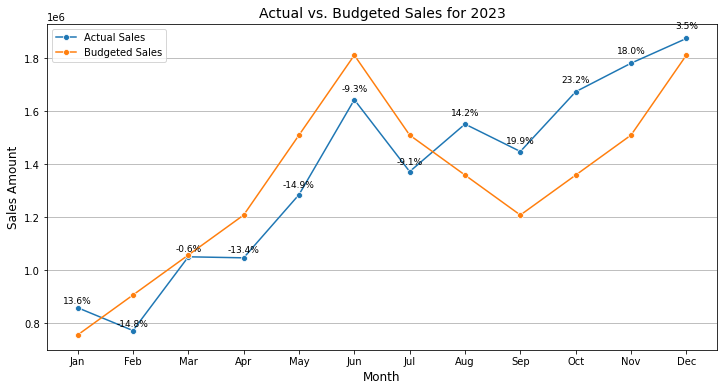

In [21]:
# Plot actual vs expected sales for 2023
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_comparison_2023, x='Month', y='ActualSales', marker='o', label='Actual Sales')
sns.lineplot(data=sales_comparison_2023, x='Month', y='Budget', marker='o', label='Budgeted Sales')

# Annotate variance %
for index, row in sales_comparison_2023.iterrows():
    plt.text(row['Month'], row['ActualSales'] + 0.02 * row['ActualSales'], f"{row['Variance %']:.1f}%", ha='center', fontsize=9)

plt.title('Actual vs. Budgeted Sales for 2023', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sales Amount', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.legend()
plt.show()



#### 6.2 Yearly Budget Variance

In [22]:
# Extract year from DateKey in sales_df and Date in budget_df
sales_df['Year'] = sales_df['DateKey'].dt.year
budget_df['Year'] = budget_df['Date'].dt.year

# Aggregate actual sales by year
actual_sales_by_year = sales_df.groupby('Year')['SalesAmount'].sum().reset_index()
actual_sales_by_year.columns = ['Year', 'ActualSales']

# Aggregate budget by year
budget_by_year = budget_df.groupby('Year')['Budget'].sum().reset_index()

# Merge the two datasets
sales_comparison_by_year = actual_sales_by_year.merge(budget_by_year, on='Year')


In [23]:
# Calculate variance and variance percentage
sales_comparison_by_year['Variance'] = sales_comparison_by_year['ActualSales'] - sales_comparison_by_year['Budget']
sales_comparison_by_year['Variance %'] = (sales_comparison_by_year['Variance'] / sales_comparison_by_year['Budget']) * 100


In [24]:
# Display variance insights by year
print(sales_comparison_by_year[['Year', 'ActualSales', 'Budget', 'Variance', 'Variance %']])


   Year  ActualSales    Budget   Variance  Variance %
0  2023  16351550.34  16000001  351549.34    2.197183
